Getting the Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
Data = pd.read_excel('SACovidData.xlsx')
Orange = pd.read_excel('Orangedata.xlsx')

In [ ]:
Data.head(6)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,ZAF,Africa,South Africa,2020-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,0.001,NaN,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,60041996,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,NaN,NaN,NaN,NaN
1,ZAF,Africa,South Africa,2020-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,60041996,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,NaN,NaN,NaN,NaN
2,ZAF,Africa,South Africa,2020-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,60041996,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,1573.2,2.81,8.1,26.201661
3,ZAF,Africa,South Africa,2020-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,60041996,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,NaN,NaN,NaN,NaN
4,ZAF,Africa,South Africa,2020-02-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,0.001,NaN,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,60041996,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,NaN,NaN,NaN,NaN
5,ZAF,Africa,South Africa,2020-02-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,60041996,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,NaN,NaN,NaN,NaN


Cleaning the data

In [ ]:
#Having a look at all the column names we have
Data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [ ]:
#Droping the columns that we do not need for predicton,
#The reamaining columns will be the features for prediction

data1 = Data.drop(['iso_code','continent', 'location', 'new_cases_smoothed', 'new_deaths_smoothed', 
          'total_cases_per_million','new_cases_per_million', 'new_cases_smoothed_per_million',
           'total_deaths_per_million', 'new_deaths_per_million','new_deaths_smoothed_per_million',
           'reproduction_rate','total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand','new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred','new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed','new_people_vaccinated_smoothed_per_hundred',
        'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million',
        'tests_units'
          ], axis = 1)

In [ ]:
#replacing null values with zeros
data2 = data1.fillna(0)
data2.tail(6)

,date,total_cases,new_cases,total_deaths,new_deaths,new_tests,total_tests,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
669,2021-12-07,3051222.0,13147.0,90002.0,27.0,52890.0,19838883.0,0.2299,4.4,26639293.0,18053081.0,15104933.0,0.0,148877.0,0.0,60041996,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,0.0,0.0,0.0,0.0
670,2021-12-08,3071064.0,19842.0,90038.0,36.0,73911.0,19912794.0,0.2461,4.1,26781642.0,18157324.0,15182986.0,0.0,142349.0,0.0,60041996,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,0.0,0.0,0.0,0.0
671,2021-12-09,3093452.0,22388.0,90060.0,22.0,75251.0,19988045.0,0.2583,3.9,0.0,0.0,0.0,0.0,0.0,0.0,60041996,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,0.0,0.0,0.0,0.0
672,2021-12-10,3112469.0,19017.0,90080.0,20.0,83515.0,20071560.0,0.2547,3.9,27043034.0,18344024.0,15330635.0,0.0,0.0,0.0,60041996,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,0.0,0.0,0.0,0.0
673,2021-12-11,3129622.0,17153.0,90116.0,36.0,104831.0,20176391.0,0.2364,4.2,0.0,0.0,0.0,0.0,0.0,0.0,60041996,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,0.0,0.0,0.0,0.0
674,2021-12-12,3167497.0,37875.0,90137.0,21.0,62414.0,20238805.0,0.2847,3.5,0.0,0.0,0.0,0.0,0.0,0.0,60041996,46.754,27.3,5.344,3.053,12294.876,18.9,200.38,5.52,8.1,33.2,43.993,2.32,64.13,0.709,0.0,0.0,0.0,0.0


In [ ]:
from datetime import datetime
data2.date = pd.to_datetime(data2.date, format = '%Y-%m-%d')
data3 = data2[['date', 'new_cases']]
data3


,date,new_cases
0,2020-02-07,0.0
1,2020-02-08,0.0
2,2020-02-09,0.0
3,2020-02-10,0.0
4,2020-02-11,0.0
...,...,...
670,2021-12-08,19842.0
671,2021-12-09,22388.0
672,2021-12-10,19017.0
673,2021-12-11,17153.0


In [ ]:
dataorange = data2[['date', 'new_cases', 'total_deaths', 'new_deaths', 'total_vaccinations']]

In [ ]:
#Transform dataframe into a time series
data3.set_index('date', inplace = True)

In [ ]:
data3

,new_cases
date,
2020-02-07,0.0
2020-02-08,0.0
2020-02-09,0.0
2020-02-10,0.0
2020-02-11,0.0
...,...
2021-12-08,19842.0
2021-12-09,22388.0
2021-12-10,19017.0


Visualize current data

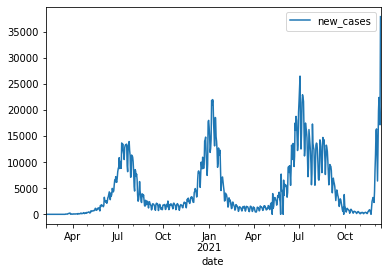

In [ ]:
data3.plot()

Clearly, a 4-month seasonality exists in data. Also, different seasonalities are not stationary. Differencing in seasons is neccessary




In [ ]:
#Differencing for non-seasonal model.Therefore, k_diff is set to 1. 
#Thus, k_seasonal_diff=True, seasonal_periods=4 since there is a cycle every 4 months.

from statsmodels.tsa.statespace.tools import diff

diffdata=diff(data3, k_diff=1, k_seasonal_diff=True, seasonal_periods=4)
diffdata

,new_cases
date,
2020-02-12,0.0
2020-02-13,0.0
2020-02-14,0.0
2020-02-15,0.0
2020-02-16,0.0
...,...
2021-12-08,6384.0
2021-12-09,7787.0
2021-12-10,1373.0


Draw ACF and PACF Plot Charts to identify the SARIMA Model

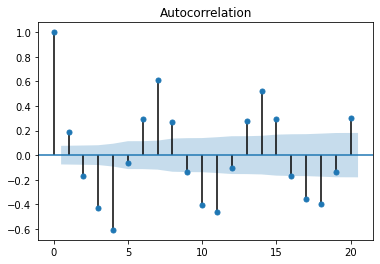

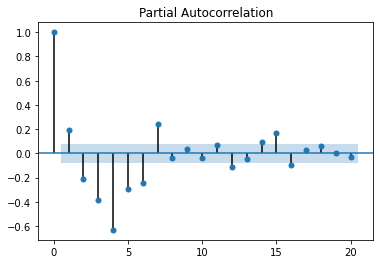

In [ ]:
sm.graphics.tsa.plot_acf(diffdata.values.squeeze(), lags=20) # You can change the lags value if you want to see more lags
sm.graphics.tsa.plot_pacf(diffdata.values.squeeze(), lags=20)
plt.show()

Run analysis model

In [ ]:
mod = sm.tsa.SARIMAX(data3, order=(0,1,0),seasonal_order=(3,1,1,6))
res = mod.fit()
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                
Dep. Variable:                         new_cases   No. Observations:                  675
Model:             SARIMAX(0, 1, 0)x(3, 1, 1, 6)   Log Likelihood               -5979.926
Date:                           Fri, 17 Dec 2021   AIC                          11969.852
Time:                                   06:59:04   BIC                          11992.373
Sample:                               02-07-2020   HQIC                         11978.576
                                    - 12-12-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6        0.1637      0.036      4.552      0.000       0.093       0.234
ar.S.L12      -0.1734      0.038     -4.616

Forecasting the data

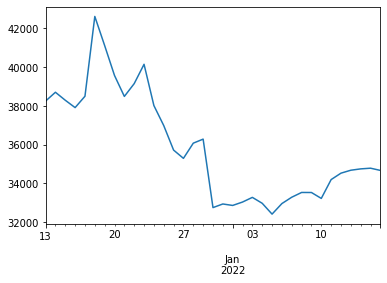

In [ ]:
res.forecast(35).plot()

In [ ]:
Orange.columns

Index(['date', 'new_cases', 'RandomForest', 'Tree', 'Feature 1'], dtype='object')

In [ ]:
Orange

,date,new_cases,RandomForest,Tree,Feature 1
0,2020-02-11,0,0.0,0.0,4
1,2020-03-05,1,0.0,0.0,27
2,2020-02-21,0,0.0,0.0,14
3,2020-02-08,0,0.0,0.0,1
4,2020-02-20,0,0.0,0.0,13
...,...,...,...,...,...
130,2021-07-15,16435,16546.1,15321.0,524
131,2021-01-11,15046,17240.9,16896.0,339
132,2021-01-09,21606,17430.1,16896.0,337
133,2021-07-01,21584,18051.9,17503.0,510


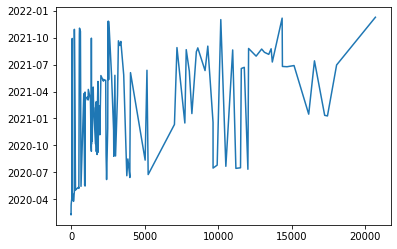

In [ ]:
plt.plot( Orange.RandomForest)

<Figure size 432x288 with 0 Axes>

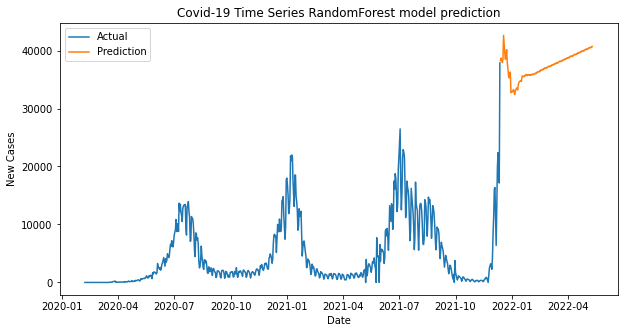

In [ ]:
plt.figure(2)
plt.figure(figsize=(10, 5))
plt.title('Covid-19 Time Series RandomForest model prediction')
plt.plot(data3, label ="Actual")
plt.plot(res.forecast(150), label ="Prediction")
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()

In [ ]:
res